In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
from pprint import pprint
import seaborn as sns
%matplotlib inline

In [29]:
with fits.open("/data/GZ_Decals/VAGC_MGS-m14_1777--20180116.fits") as hdul:
    ra = np.array(hdul[1].data["RA      "])
    dec = np.array(hdul[1].data["DEC     "])
    petro_mag = np.array(hdul[1].data["PETROMAG"][:, 2])
    z = np.array(hdul[1].data["Z       "])
    MGS = pd.DataFrame(np.array((ra, dec, petro_mag, z)).T, columns=["ra", "dec", "petro_mag", "redshift"])

    # MGS = MGS.round({"ra":7, "dec":7})

In [30]:
with fits.open("/data/renhaoye/decals_2022/MGS_out_DECaLS.fits") as hdul:
    ra = np.array(hdul[1].data["RA"])
    dec = np.array(hdul[1].data["DEC"])
    petro_mag = np.array(hdul[1].data["PETROMAG"][:, 2])
    z = np.array(hdul[1].data["Z"])
    out_decals = pd.DataFrame(np.array((ra, dec, petro_mag, z)).T, columns=["ra", "dec", "petro_mag", "redshift"])
    # out_decals = out_decals.round({"ra":7, "dec":7})

In [31]:
decals_dataset = pd.read_csv("/data/renhaoye/decals_2022/dataset_decals.csv", index_col=0)
# decals_dataset = decals_dataset.round({"ra":6, "dec":6})

In [33]:
auto_catalog_path = "/data/renhaoye/decals_2022/gz_decals_auto_posteriors.parquet"
df_auto = pd.read_parquet(auto_catalog_path).rename(columns=lambda x: x.replace("-", "_"))
# df_auto = df_auto.round({"ra":7, "dec":7})

In [61]:
import astropy.units as u
from astropy.coordinates import SkyCoord
def match(catalog_1, catalog_2):
    sdss = SkyCoord(ra=catalog_1.ra*u.degree, dec=catalog_1.dec*u.degree)
    decals = SkyCoord(ra=catalog_2.ra*u.degree, dec=catalog_2.dec*u.degree)
    idx, d2d, d3d = sdss.match_to_catalog_sky(decals)
    max_sep = 4 * 0.262 * u.arcsec
    distance_idx = d2d < max_sep
    # sdss_matches = sdss[distance_idx]   # sdss表中的坐标，顺序和decals_matches相同，和sdss_df顺序不同
    # matches = idx[distance_idx]  # decals表中的坐标，顺序和decals_df不同
    # decals_matches = decals[matches]  # decals表中的坐标，顺序和decals_df不同
    sdss_matches = catalog_1.iloc[distance_idx]
    matches = idx[distance_idx]
    decal_matches = catalog_2.iloc[matches]
    test = sdss_matches.loc[:].rename(columns={"ra":"sdss_ra", "dec":"sdss_dec"})
    test.insert(0, 'ID', range(len(test)))
    decal_matches.insert(0, 'ID', range(len(decal_matches)))
    new_df = pd.merge(test, decal_matches, how="inner", on=["ID"])
    return new_df.drop("ID", axis=1)

In [69]:
merger = match(MGS, df_auto)

In [72]:
data = match(merger, decals_dataset)

In [4]:
decals_pred = pd.read_csv("/data/renhaoye/decals_2022/decals_test_prob.csv", index_col=0)
sdss_pred = pd.read_csv("/data/renhaoye/decals_2022/sdss_test_prob.csv", index_col=0)

In [26]:
decals_right = decals_pred.query("label == pred")
sdss_right = sdss_pred.query("label == pred")
decals_wrong = decals_pred.query("label != pred")
sdss_wrong = sdss_pred.query("label != pred")

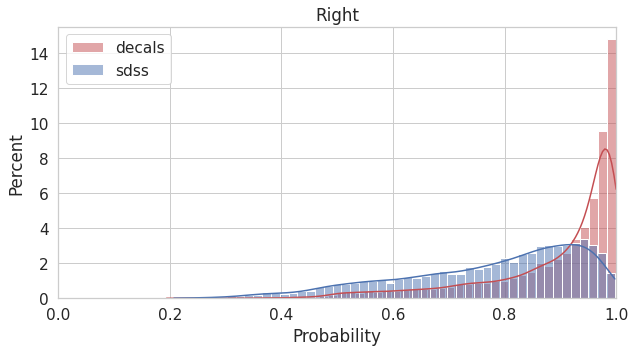

In [79]:
plt.figure(figsize=(10, 5))
sns.set()
sns.set_theme(font='Times New Roman',font_scale=1.4, palette=None)
sns.set_style("whitegrid")
# plt.hist(decals_right.prob, density=True, histtype="step", label="decals", bins=100)
# plt.hist(sdss_right.prob, density=True, histtype="step", label="sdss", bins=100)
sns.histplot(decals_right.prob, stat="density", label="decals", bins=50,kde=True, color="r")
sns.histplot(sdss_right.prob, stat="density", label="sdss", bins=50,kde=True)
plt.legend()
plt.title("Right")
plt.xlabel("Probability")
plt.ylabel("Percent")
plt.xlim(0, 1)
plt.show()

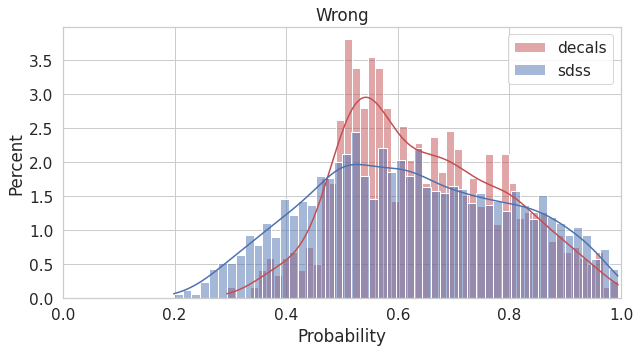

In [80]:
plt.figure(figsize=(10, 5))
sns.set()
sns.set_theme(font='Times New Roman',font_scale=1.4, palette=None)
sns.set_style("whitegrid")
# plt.hist(decals_wrong.prob, density=True, histtype="step", label="decals", bins=50)
# plt.hist(sdss_wrong.prob, density=True, histtype="step", label="sdss", bins=50)
sns.histplot(decals_wrong.prob, stat="density", label="decals", bins=50, color="r",kde=True)
sns.histplot(sdss_wrong.prob, stat="density", label="sdss", bins=50,kde=True)
plt.legend()
plt.title("Wrong")
plt.xlabel("Probability")
plt.ylabel("Percent")
plt.xlim(0, 1)
plt.show()

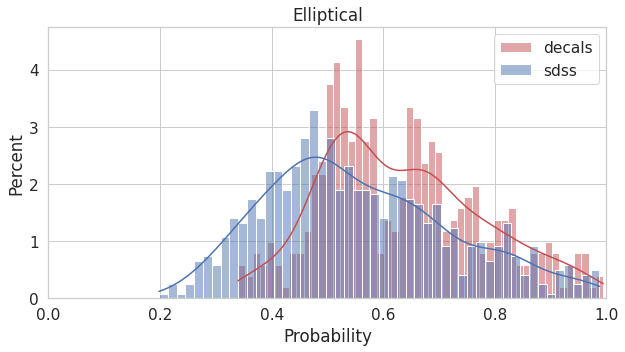

In [94]:
plt.figure(figsize=(10, 5))
sns.set()
sns.set_theme(font='Times New Roman',font_scale=1.4, palette=None)
sns.set_style("whitegrid")
# plt.hist(decals_right.prob, density=True, histtype="step", label="decals", bins=100)
# plt.hist(sdss_right.prob, density=True, histtype="step", label="sdss", bins=100)
sns.histplot(decals_wrong.query("label == 1 or label == 2 or label == 3").prob,
             stat="density", label="decals", bins=50,kde=True, color="r")
sns.histplot(sdss_wrong.query("label == 1 or label == 2 or label == 3").prob,
             stat="density", label="sdss", bins=50,kde=True)
plt.legend()
plt.title("Elliptical")
plt.xlabel("Probability")
plt.ylabel("Percent")
plt.xlim(0, 1)
plt.show()

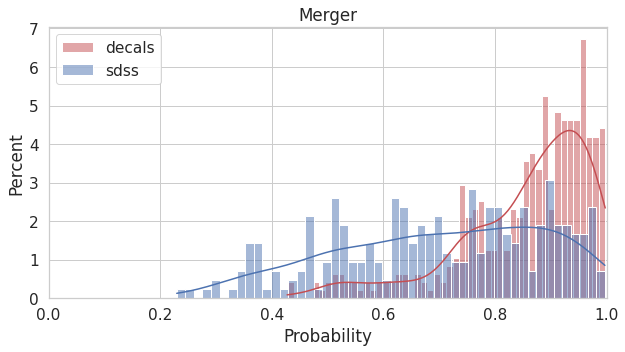

In [82]:
plt.figure(figsize=(10, 5))
sns.set()
sns.set_theme(font='Times New Roman',font_scale=1.4, palette=None)
sns.set_style("whitegrid")
# plt.hist(decals_right.prob, density=True, histtype="step", label="decals", bins=100)
# plt.hist(sdss_right.prob, density=True, histtype="step", label="sdss", bins=100)
sns.histplot(decals_pred.query("label == 0").prob,
             stat="density", label="decals", bins=50,kde=True, color="r")
sns.histplot(sdss_pred.query("label == 0").prob,
             stat="density", label="sdss", bins=50,kde=True)
plt.legend()
plt.title("Merger")
plt.xlabel("Probability")
plt.ylabel("Percent")
plt.xlim(0, 1)
plt.show()

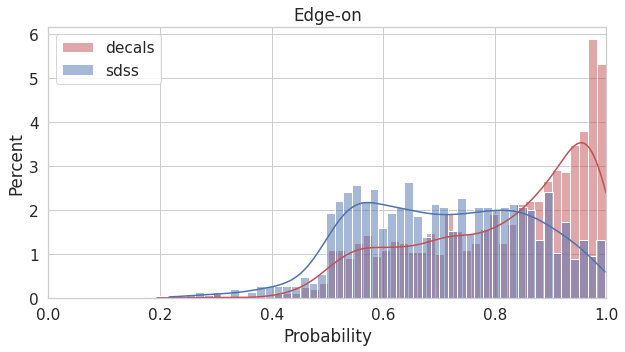

In [83]:
plt.figure(figsize=(10, 5))
sns.set()
sns.set_theme(font='Times New Roman',font_scale=1.4, palette=None)
sns.set_style("whitegrid")
# plt.hist(decals_right.prob, density=True, histtype="step", label="decals", bins=100)
# plt.hist(sdss_right.prob, density=True, histtype="step", label="sdss", bins=100)
sns.histplot(decals_pred.query("label == 4").prob,
             stat="density", label="decals", bins=50,kde=True, color="r")
sns.histplot(sdss_pred.query("label == 4").prob,
             stat="density", label="sdss", bins=50,kde=True)
plt.legend()
plt.title("Edge-on")
plt.xlabel("Probability")
plt.ylabel("Percent")
plt.xlim(0, 1)
plt.show()

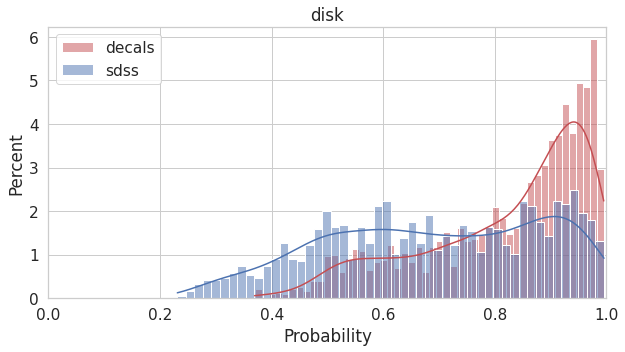

In [84]:
plt.figure(figsize=(10, 5))
sns.set()
sns.set_theme(font='Times New Roman',font_scale=1.4, palette=None)
sns.set_style("whitegrid")
# plt.hist(decals_right.prob, density=True, histtype="step", label="decals", bins=100)
# plt.hist(sdss_right.prob, density=True, histtype="step", label="sdss", bins=100)
sns.histplot(decals_pred.query("label == 5").prob,
             stat="density", label="decals", bins=50,kde=True, color="r")
sns.histplot(sdss_pred.query("label == 5").prob,
             stat="density", label="sdss", bins=50,kde=True)
plt.legend()
plt.title("disk")
plt.xlabel("Probability")
plt.ylabel("Percent")
plt.xlim(0, 1)
plt.show()

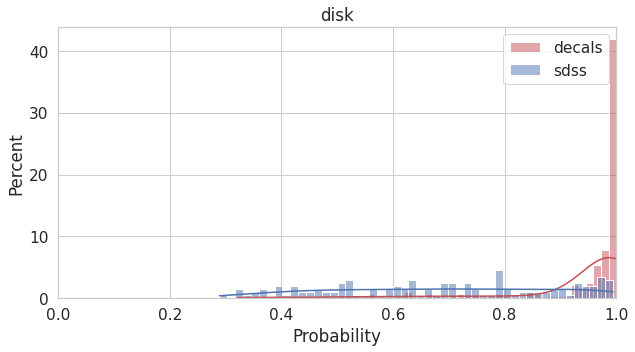

In [89]:
plt.figure(figsize=(10, 5))
sns.set()
sns.set_theme(font='Times New Roman',font_scale=1.4, palette=None)
sns.set_style("whitegrid")
# plt.hist(decals_right.prob, density=True, histtype="step", label="decals", bins=100)
# plt.hist(sdss_right.prob, density=True, histtype="step", label="sdss", bins=100)
sns.histplot(decals_pred.query("label == 6").prob,
             stat="density", label="decals", bins=50,kde=True, color="r")
sns.histplot(sdss_pred.query("label == 6").prob,
             stat="density", label="sdss", bins=50,kde=True)
plt.legend()
plt.title("disk")
plt.xlabel("Probability")
plt.ylabel("Percent")
plt.xlim(0, 1)
plt.show()

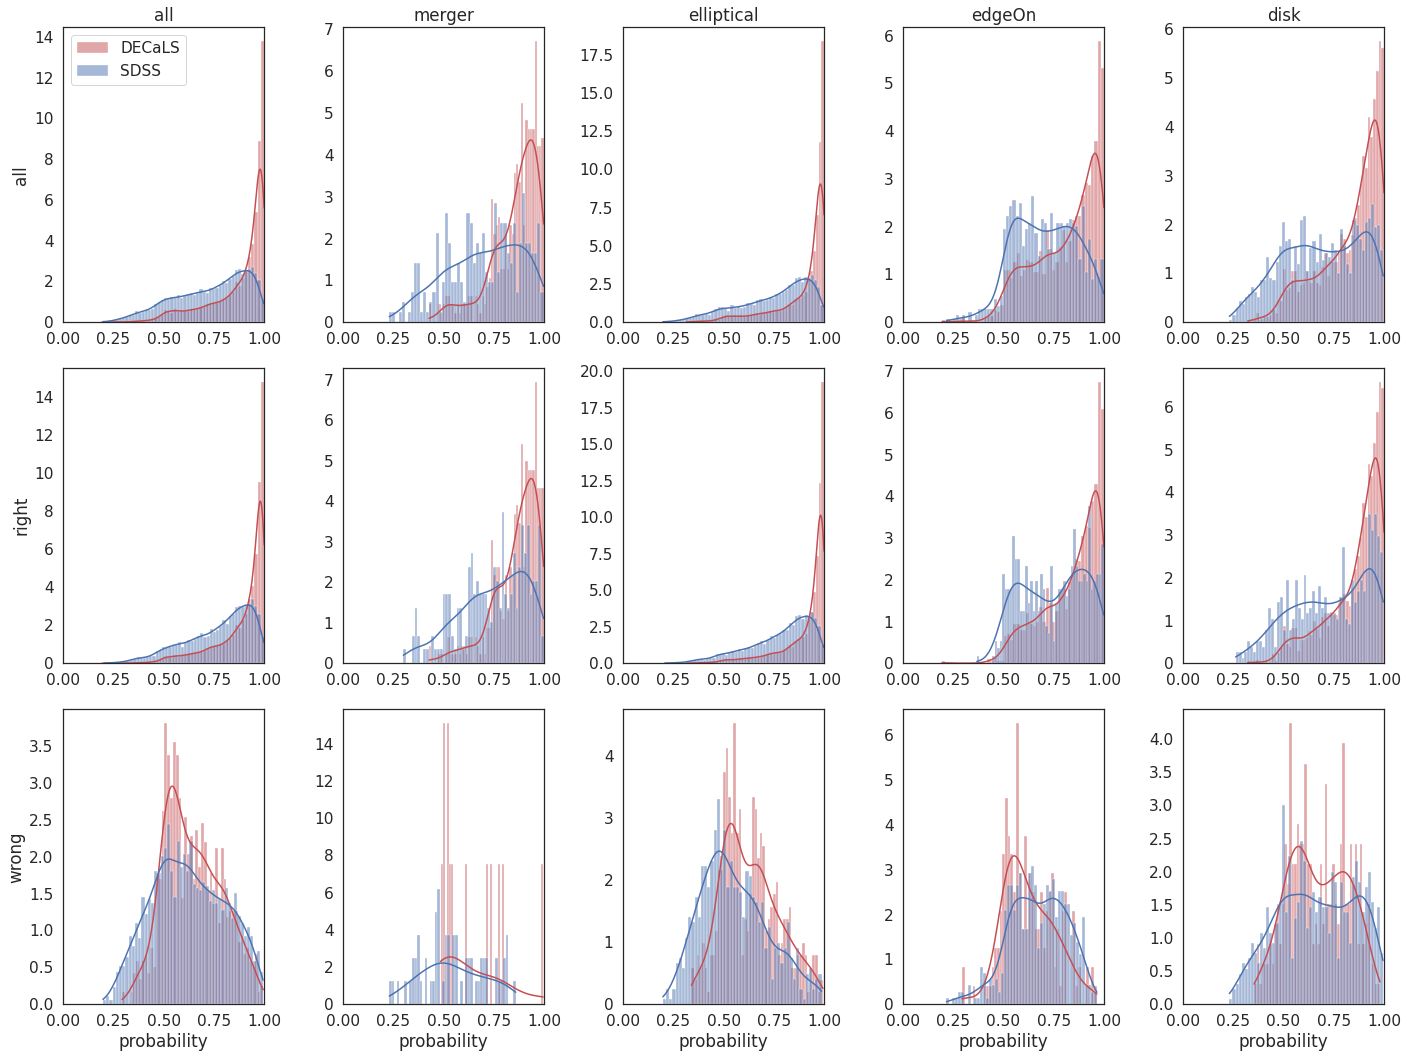

In [117]:
fig = plt.figure(figsize=(20, 15))
sns.set()
sns.set_theme(font='Times New Roman',font_scale=1.4, palette=None)
sns.set_style("white")
ax = fig.add_subplot(3, 5, 1)
ax.set_title("all")
sns.histplot(decals_pred.prob,
             stat="density", label="DECaLS", bins=50, kde=True, color="r")
sns.histplot(sdss_pred.prob,
             stat="density", label="SDSS", bins=50, kde=True)
ax.set_xlabel(None)
ax.set_ylabel("all")
ax.legend(loc="upper left")
plt.xlim(0, 1)

ax = fig.add_subplot(3, 5, 6)
sns.histplot(decals_pred.query("label == pred").prob,
             stat="density", label="decals", bins=50, kde=True, color="r")
sns.histplot(sdss_pred.query("label == pred").prob,
             stat="density", label="sdss", bins=50, kde=True)
ax.set_xlabel(None)
ax.set_ylabel("right")
plt.xlim(0, 1)

ax = fig.add_subplot(3, 5, 11)
sns.histplot(decals_pred.query("label != pred").prob,
             stat="density", label="decals", bins=50, kde=True, color="r")
sns.histplot(sdss_pred.query("label != pred").prob,
             stat="density", label="sdss", bins=50, kde=True)
ax.set_xlabel("probability")
ax.set_ylabel("wrong")
plt.xlim(0, 1)

ax = fig.add_subplot(3, 5, 2)
ax.set_title("merger")
sns.histplot(decals_pred.query("label == 0").prob,
             stat="density", label="decals", bins=50, kde=True, color="r")
sns.histplot(sdss_pred.query("label == 0").prob,
             stat="density", label="sdss", bins=50, kde=True)
ax.set_xlabel(None)
ax.set_ylabel(None)
plt.xlim(0, 1)

ax = fig.add_subplot(3, 5, 7)
sns.histplot(decals_right.query("label == 0").prob,
             stat="density", label="decals", bins=50, kde=True, color="r")
sns.histplot(sdss_right.query("label == 0").prob,
             stat="density", label="sdss", bins=50, kde=True)
ax.set_xlabel(None)
ax.set_ylabel(None)
plt.xlim(0, 1)

ax = fig.add_subplot(3, 5, 12)
sns.histplot(decals_wrong.query("label == 0").prob,
             stat="density", label="decals", bins=50, kde=True, color="r")
sns.histplot(sdss_wrong.query("label == 0").prob,
             stat="density", label="sdss", bins=50, kde=True)
ax.set_xlabel("probability")
ax.set_ylabel(None)
plt.xlim(0, 1)

ax = fig.add_subplot(3, 5, 3)
ax.set_title("elliptical")
sns.histplot(decals_pred.query("label == 1 or label == 2 or label == 3").prob,
             stat="density", label="decals", bins=50, kde=True, color="r")
sns.histplot(sdss_pred.query("label == 1 or label == 2 or label == 3").prob,
             stat="density", label="sdss", bins=50, kde=True)
ax.set_xlabel(None)
ax.set_ylabel(None)
plt.xlim(0, 1)

ax = fig.add_subplot(3, 5, 8)
sns.histplot(decals_right.query("label == 1 or label == 2 or label == 3").prob,
             stat="density", label="decals", bins=50, kde=True, color="r")
sns.histplot(sdss_right.query("label == 1 or label == 2 or label == 3").prob,
             stat="density", label="sdss", bins=50, kde=True)
ax.set_xlabel(None)
ax.set_ylabel(None)
plt.xlim(0, 1)

ax = fig.add_subplot(3, 5, 13)
sns.histplot(decals_wrong.query("label == 1 or label == 2 or label == 3").prob,
             stat="density", label="decals", bins=50, kde=True, color="r")
sns.histplot(sdss_wrong.query("label == 1 or label == 2 or label == 3").prob,
             stat="density", label="sdss", bins=50, kde=True)
ax.set_xlabel("probability")
ax.set_ylabel(None)
plt.xlim(0, 1)

ax = fig.add_subplot(3, 5, 4)
ax.set_title("edgeOn")
sns.histplot(decals_pred.query("label == 4").prob,
             stat="density", label="decals", bins=50, kde=True, color="r")
sns.histplot(sdss_pred.query("label == 4").prob,
             stat="density", label="sdss", bins=50, kde=True)
ax.set_xlabel(None)
ax.set_ylabel(None)
plt.xlim(0, 1)

ax = fig.add_subplot(3, 5, 9)
sns.histplot(decals_right.query("label == 4").prob,
             stat="density", label="decals", bins=50, kde=True, color="r")
sns.histplot(sdss_right.query("label == 4").prob,
             stat="density", label="sdss", bins=50, kde=True)
ax.set_xlabel(None)
ax.set_ylabel(None)
plt.xlim(0, 1)

ax = fig.add_subplot(3, 5, 14)
sns.histplot(decals_wrong.query("label == 4").prob,
             stat="density", label="decals", bins=50, kde=True, color="r")
sns.histplot(sdss_wrong.query("label == 4").prob,
             stat="density", label="sdss", bins=50, kde=True)
ax.set_xlabel("probability")
ax.set_ylabel(None)
plt.xlim(0, 1)

ax = fig.add_subplot(3, 5, 5)
ax.set_title("disk")
sns.histplot(decals_pred.query("label == 5 or label == 6").prob,
             stat="density", label="decals", bins=50, kde=True, color="r")
sns.histplot(sdss_pred.query("label == 5 or label == 6").prob,
             stat="density", label="sdss", bins=50, kde=True)
ax.set_xlabel(None)
ax.set_ylabel(None)
plt.xlim(0, 1)

ax = fig.add_subplot(3, 5, 10)
sns.histplot(decals_right.query("label == 5 or label == 6").prob,
             stat="density", label="decals", bins=50, kde=True, color="r")
sns.histplot(sdss_right.query("label == 5 or label == 6").prob,
             stat="density", label="sdss", bins=50, kde=True)
ax.set_xlabel(None)
ax.set_ylabel(None)
plt.xlim(0, 1)

ax = fig.add_subplot(3, 5, 15)
sns.histplot(decals_wrong.query("label == 5 or label == 6").prob,
             stat="density", label="decals", bins=50, kde=True, color="r")
sns.histplot(sdss_wrong.query("label == 5 or label == 6").prob,
             stat="density", label="sdss", bins=50, kde=True)
ax.set_xlabel("probability")
ax.set_ylabel(None)
plt.xlim(0, 1)

plt.tight_layout()
plt.show()